In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import lime.lime_tabular
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from SyntheticDataset import SyntheticDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"] + "/synth_multi"

In [3]:
config_file = open('visual_config.json')
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Multi-Class Classification

## Create the Dataset

In [4]:
min_val = -100
max_val = 100
num_rows = 1500
num_features = 10
num_classes = 10
rand_coef_class = 0.05
rand_coef = []
for i in range(num_features):
    coef = [0.9 for x in range(num_classes)]
    coef[i % num_classes] = rand_coef_class
    rand_coef.append(coef)

# Each variable contributes to one class, the one with the same number (e.g. Var0 -> Class 0, Var1 -> Class 1)

std_dev = np.array([1.5 - (0.1 * i) for i in range(num_features)])
class_sep = np.ones(10) * 0.5

features_names = ["Var" + (str(x)) for x in range(num_features)]
dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, rand_coef, seed=42)
#dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, norm_dist=True, seed=42, std_dev_perc=std_dev, class_sep_perc=class_sep)
dataset.generate()
dataset.get_data()

array([[-100.        ,  -12.22431205,   71.71958398, ...,  -74.37727346,
          -9.92281242,    0.        ],
       [-100.        ,   28.77302402,   64.55232265, ...,   26.33287982,
          51.61754802,    0.        ],
       [-100.        ,   78.62422426,   55.67669941, ...,   48.95243118,
          93.50194649,    0.        ],
       ...,
       [  97.41105581,  100.        ,  -44.83053703, ...,   56.62899915,
         100.        ,    9.        ],
       [  48.27427608,  -27.06113521,  100.        , ...,   23.96410892,
         100.        ,    9.        ],
       [ -24.90312501,   -7.89939685,  100.        , ...,   58.71803567,
         100.        ,    9.        ]])

In [5]:
X = dataset.get_x()
y = dataset.get_y()
# scaler = RobustScaler()
# X = scaler.fit_transform(X, y)

In [6]:
rand_coef

[[0.05, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.05, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.05, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.05, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.05, 0.9, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.9, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.9, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.9, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.9],
 [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05]]

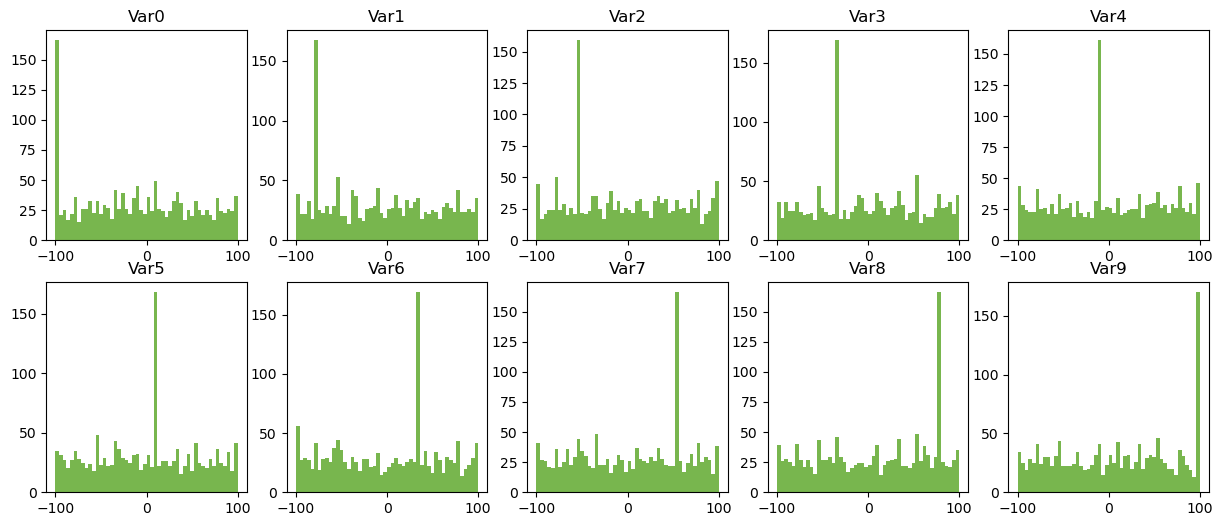

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = ax.flatten()

cont = 0
for x in ax:

    x.hist(X[:, cont], bins=50, color=green_color)
    x.set_title(f"Var{cont}")
    cont += 1

plt.show()

## Split the Dataset

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

Y_train = [int(x) for x in Y_train]
Y_test = [int(x) for x in Y_test]

cross_val = StratifiedKFold(n_splits=5)

X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

## Instance to extract local explanations for all models

In [9]:
Exp_index = 3
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]
print(f"Instance:\n{Exp_inst_pd}\n\nClass: {Exp_inst_class}") #"Name" and "dtype" are not part of the instance, they must be ignored

Instance:
Var0    100.000000
Var1     24.552034
Var2     95.022664
Var3    -30.335816
Var4     60.149506
Var5     11.791368
Var6    -52.948011
Var7    -89.422334
Var8     23.202178
Var9    100.000000
Name: 3, dtype: float64

Class: 9


# Classification

In [10]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [11]:
param_grid = {"max_iter": [100, 500, 1000, 2000],
              "solver": ["lbfgs", "newton-cg", "sag", "saga"], 
              "C": [0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val, scoring=["accuracy"])
   
lr_init_t = time.time()
lr_grid.fit(X_train, Y_train)
lr_fin_t = time.time()

lr_duration = lr_fin_t - lr_init_t

print(f"{lr_duration} segundos")
 
print(lr_grid.best_params_)
print(f"Best Score: {lr_grid.best_score_}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
25.737277269363403 segundos
{'C': 0.01, 'max_iter': 1000, 'solver': 'lbfgs'}
Best Score: 0.4375


In [12]:
lr_clf = lr_grid.best_estimator_

Accuracy: 42.0%


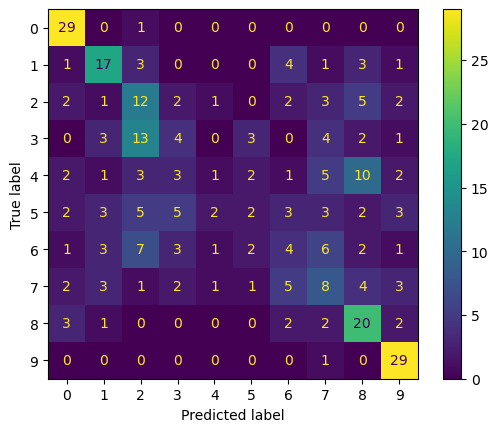

In [13]:
lr_ye = lr_clf.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_ye)

lr_acc = 1 - (np.sum(Y_test != lr_ye) / len(Y_test))
print(f"Accuracy: {round(lr_acc, 3) * 100}%")

ConfusionMatrixDisplay.from_predictions(Y_test, lr_ye)

plt.show()

In [14]:
plt.figure(figsize=(7,5))

lr_accs = perf_analysis.acc_for_class(lr_cm, colors=green_color, title="Logistic Regression")

plt.show()

<Figure size 700x500 with 0 Axes>

### Extract Explanations

#### Local

##### Local - <i>Local Model-Agnostic Explanations</i> (LIME)

In [15]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [16]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [17]:
shap.initjs()

In [18]:
lr_shap_init = time.time()
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

In [19]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)-

In [20]:
shap.initjs()

In [21]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)
lr_shap_fin = time.time()
lr_shap_dur = lr_shap_fin - lr_shap_init

  0%|          | 0/300 [00:00<?, ?it/s]

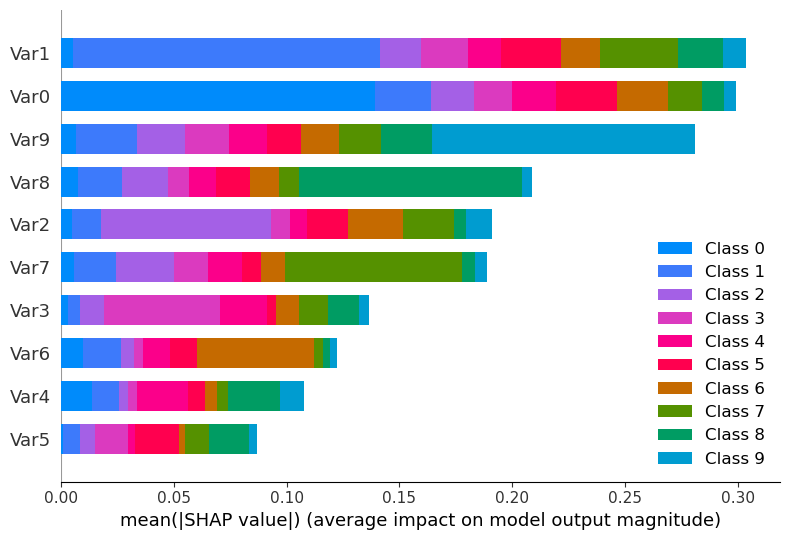

In [22]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar", class_inds="original")


## <i>Random Forest</i> (RF)

In [23]:
param_grid = {"n_estimators": [100, 250, 500, 1000, 2000],
              "bootstrap": [True, False],
              "max_features": ["sqrt", "log2", None]}
   
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit="accuracy", verbose=3, cv=cross_val, n_jobs=-1, scoring=["accuracy"]) 
   
rf_init_t = time.time() 
rf_grid.fit(X_train, Y_train) 
rf_fin_t = time.time()

rf_duration = rf_fin_t - rf_init_t

print(f"{rf_duration} segundos")
 
print(rf_grid.best_params_)
print(f"Best Score: {rf_grid.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
80.78035306930542 segundos
{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 1000}
Best Score: 0.9275


In [24]:
rf_clf = rf_grid.best_estimator_

Accuracy: 91.3%


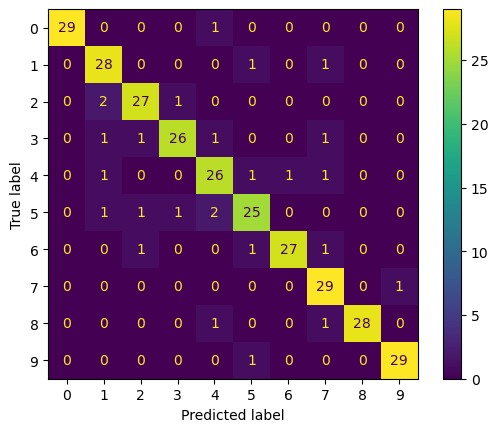

In [25]:
rf_ye = rf_clf.predict(X_test)
rf_cm = confusion_matrix(Y_test, rf_ye)

rf_acc = 1 - (np.sum(Y_test != rf_ye) / len(Y_test))
print(f"Accuracy: {round(rf_acc, 3) * 100}%")

ConfusionMatrixDisplay.from_predictions(Y_test, rf_ye)

plt.show()

In [26]:
plt.figure(figsize=(7,5))

rf_accs = perf_analysis.acc_for_class(rf_cm, colors=green_color, title="Random Forest")

plt.show()

<Figure size 700x500 with 0 Axes>

### Extract Explanations


##### Local - <i>Local Model-Agnostic Explanations</i> (LIME)

In [27]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [28]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [29]:
rf_shap_init = time.time()
rf_SHAP_exp = shap.TreeExplainer(rf_clf)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [30]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [31]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)

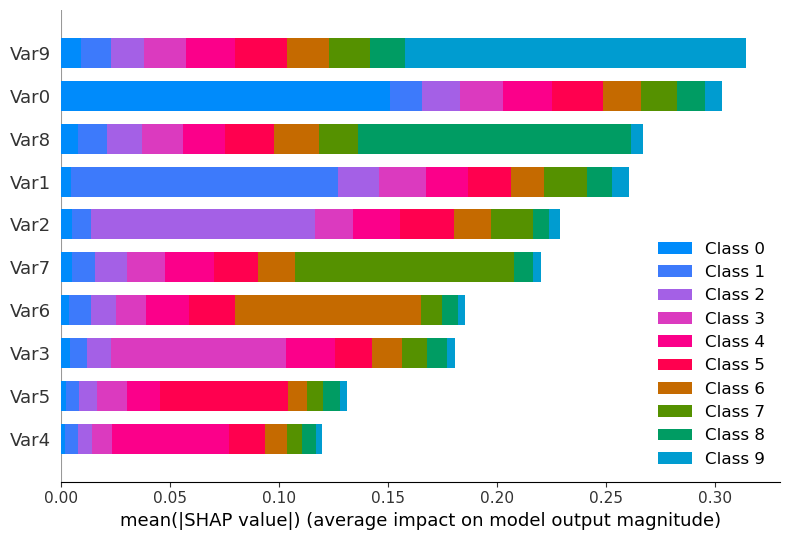

In [32]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar", class_inds="original")
rf_shap_fin = time.time()
rf_shap_dur = rf_shap_fin - rf_shap_init

# <i>Support Vector Machines</i> (SVM)

In [33]:
param_grid = {"kernel": ["rbf", "sigmoid"],
              "C": [0.05, 0.1, 0.5, 1, 10, 100],
              "decision_function_shape": ["ovo", "ovr"],
              "gamma": ["auto", "scale"]}
   
svm_grid = GridSearchCV(SVC(cache_size=1000, probability=True, random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val, scoring=["accuracy"])

svm_init_t = time.time()
svm_grid.fit(X_train, Y_train)
svm_fin_t = time.time()

svm_duration = svm_fin_t - svm_init_t

print(f"{svm_duration} segundos")
 
# print best parameter after tuning 
print(svm_grid.best_params_)
print(f"Best Score: {svm_grid.best_score_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
14.86167860031128 segundos
{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.4283333333333334


In [34]:
svm_clf = svm_grid.best_estimator_
#svm_clf = SVC(kernel="linear", C=0.1, random_state=42).fit(X_train, Y_train)

Accuracy: 42.0%


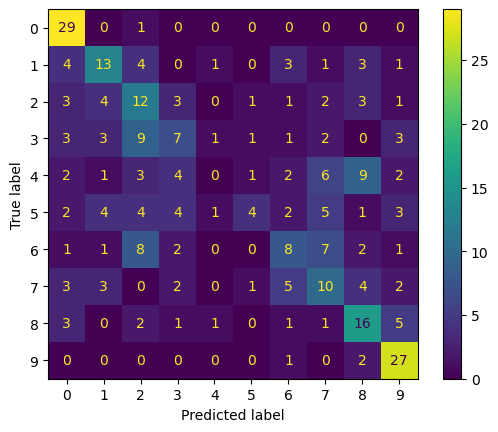

In [35]:
svm_ye = svm_clf.predict(X_test)
svm_cm = confusion_matrix(Y_test, svm_ye)

svm_acc = 1 - (np.sum(Y_test != svm_ye) / len(Y_test))
print(f"Accuracy: {round(svm_acc, 3) * 100}%")

ConfusionMatrixDisplay.from_predictions(Y_test, svm_ye)

plt.show()

In [36]:
plt.figure(figsize=(7,5))

svm_accs = perf_analysis.acc_for_class(svm_cm, colors=green_color, title="Support Vector Machines")

plt.show()

<Figure size 700x500 with 0 Axes>

### Extract Explanations


#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [37]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [38]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [39]:
svm_shap_init = time.time()
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [40]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [41]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)
svm_shap_fin = time.time()
svm_shap_dur = svm_shap_fin - svm_shap_init

  0%|          | 0/300 [00:00<?, ?it/s]

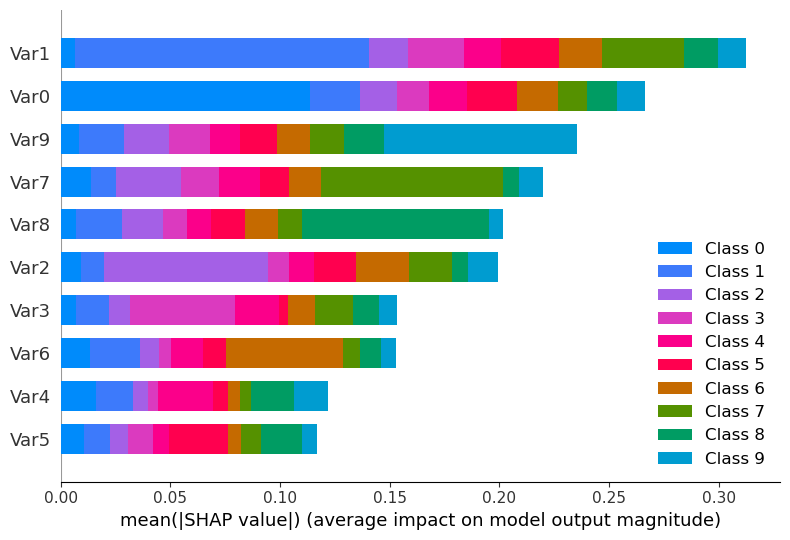

In [42]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar", class_inds="original")

## <i>Explainable Boosting Machine</i> (EBM)

In [43]:
param_grid = {"smoothing_rounds": [500, 1000],
              "cyclic_progress": [0, 0.5],
              "max_bins": [ 1024, 2048]}


ebm_grid = GridSearchCV(ExplainableBoostingClassifier(interactions = 0, random_state=42), param_grid, refit="accuracy", verbose=3, n_jobs=-1, cv=cross_val, scoring=["accuracy"]) 

ebm_init_t = time.time()
ebm_grid.fit(X_train_pd, Y_train) 
ebm_fin_t = time.time()

ebm_duration = ebm_fin_t - ebm_init_t

print(f"{ebm_duration} segundos")

print(ebm_grid.best_params_)
print(f"Best Score: {ebm_grid.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
1012.2426767349243 segundos
{'cyclic_progress': 0, 'max_bins': 1024, 'smoothing_rounds': 500}
Best Score: 0.95


In [44]:
ebm_clf = ebm_grid.best_estimator_

Accuracy: 95.0%


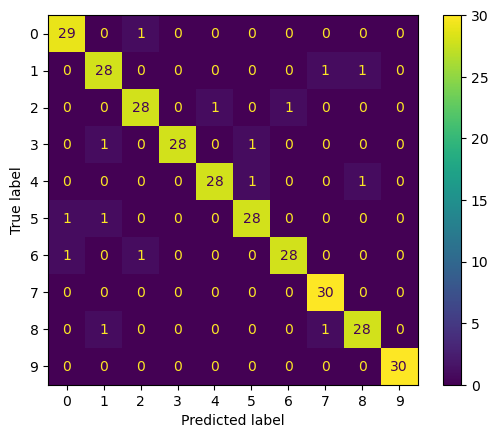

In [45]:
ebm_ye = ebm_clf.predict(X_test)
ebm_cm = confusion_matrix(Y_test, ebm_ye)

ebm_acc = 1 - (np.sum(Y_test != ebm_ye) / len(Y_test))
print(f"Accuracy: {round(ebm_acc, 3) * 100}%")

ConfusionMatrixDisplay.from_predictions(Y_test, ebm_ye)

plt.show()

In [46]:
plt.figure(figsize=(7,5))

ebm_accs = perf_analysis.acc_for_class(ebm_cm, colors=green_color, title="Explainable Boosting Machine")

plt.show()

<Figure size 700x500 with 0 Axes>

### Extract Explanations

In [47]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2277581425936/ -->

In [48]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2277845064016/ -->

# Summary

In [49]:
visual = Visualization()

## Time

In [50]:
time_pd_cols = ["LR", "RF", "SVM", "EBM"]
fit_durs = [round(x, 1) for x in [lr_duration, rf_duration, svm_duration, ebm_duration]]
shap_durs = [round(x, 1) for x in [lr_shap_dur, rf_shap_dur, svm_shap_dur]]
pd_vals = [fit_durs, shap_durs]

duration_summary = pd.DataFrame(pd_vals, columns=time_pd_cols, index=["Fit", "SHAP"])
duration_summary.columns.names = ["Task"]
duration_summary

Task    LR    RF     SVM     EBM
Fit   25.7  80.8    14.9  1012.2
SHAP  44.1  36.6  1020.0     NaN

In [51]:
latex_str = duration_summary.columns.name + "".join([" & " + x for x in duration_summary.columns]) + " \\\ \n"
for i, row in duration_summary.iterrows():

    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_multi_gs_duration.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Metrics

In [60]:
lr_metrics = lr_accs.rename(columns={0: "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_accs.rename(columns={0: "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_accs.rename(columns={0: "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_accs.rename(columns={0: "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]
avr_accs = [lr_acc, rf_acc, svm_acc, ebm_acc]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
# overall_metrics.loc[10] = [round(x, 2) for x in avr_accs]
# overall_metrics = overall_metrics.rename(index={10: "Average"})
display(overall_metrics)

Classes    LR    RF   SVM   EBM
0        0.97  0.97  0.97  0.97
1        0.57  0.93  0.43  0.93
2        0.40  0.90  0.40  0.93
3        0.13  0.87  0.23  0.93
4        0.03  0.87  0.00  0.93
5        0.07  0.83  0.13  0.93
6        0.13  0.90  0.27  0.93
7        0.27  0.97  0.33  1.00
8        0.67  0.93  0.53  0.93
9        0.97  0.97  0.90  1.00
Average  0.42  0.91  0.42  0.95

In [53]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [54]:
for i, row in overall_metrics.iterrows():
    
    aux_str = str(i)
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_multi_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

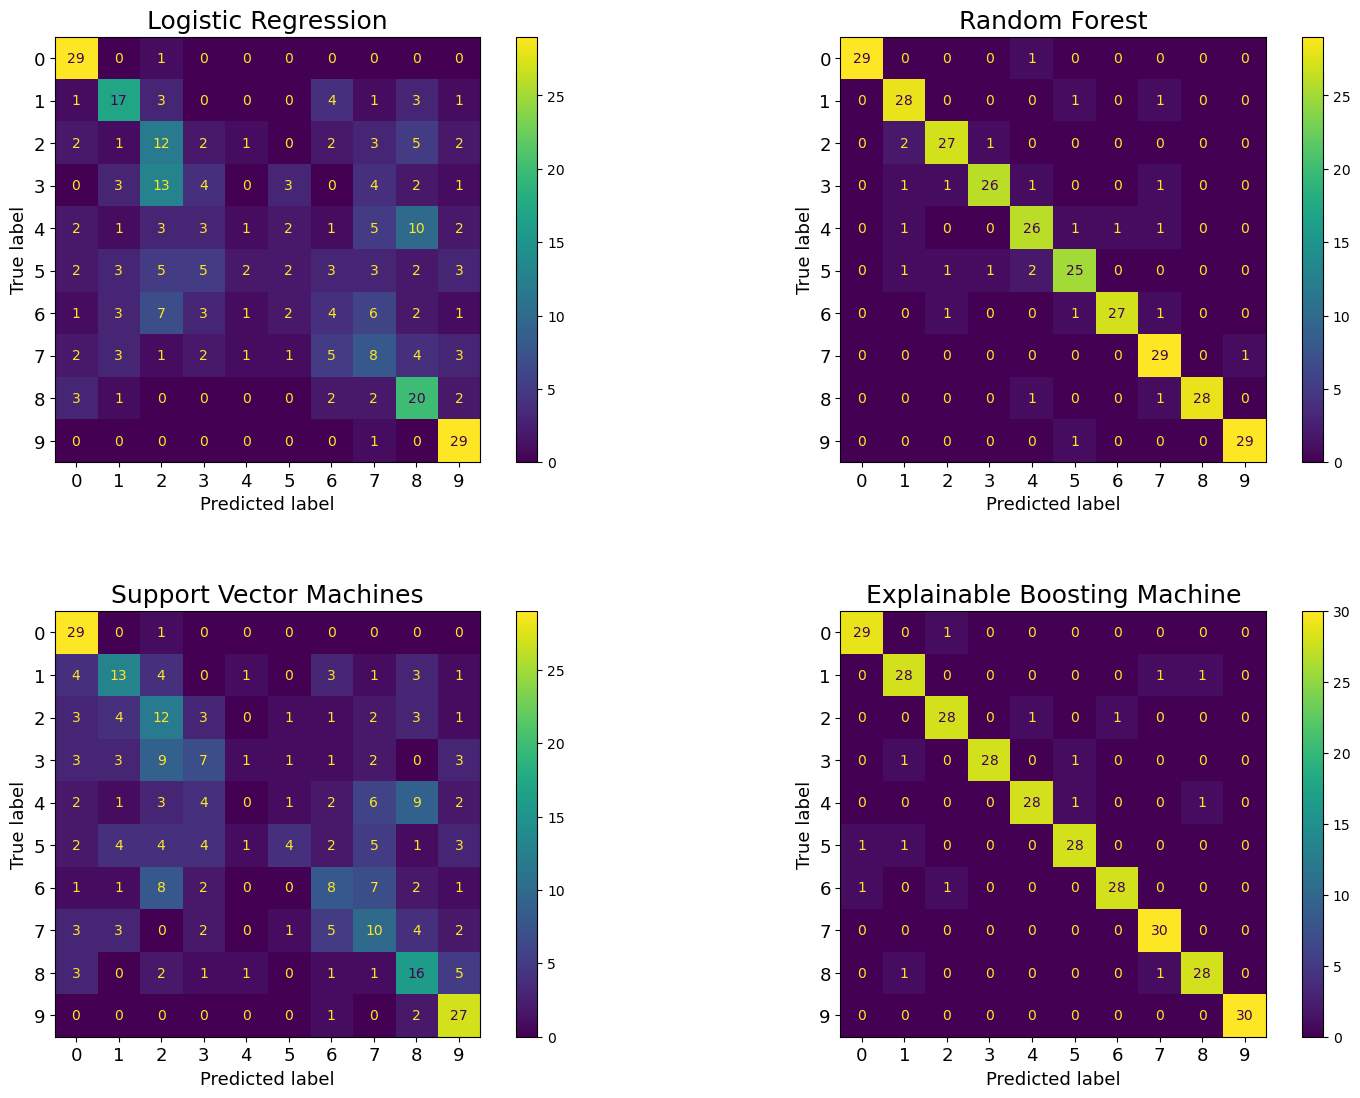

In [62]:
visual.confusion_matrices_pred([Y_test, Y_test, Y_test, Y_test],
                          [lr_ye, rf_ye, svm_ye, ebm_ye],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"])

plt.savefig(f"{logs_dir}/synth_multi_conf_matrices.png", bbox_inches="tight")

plt.show()

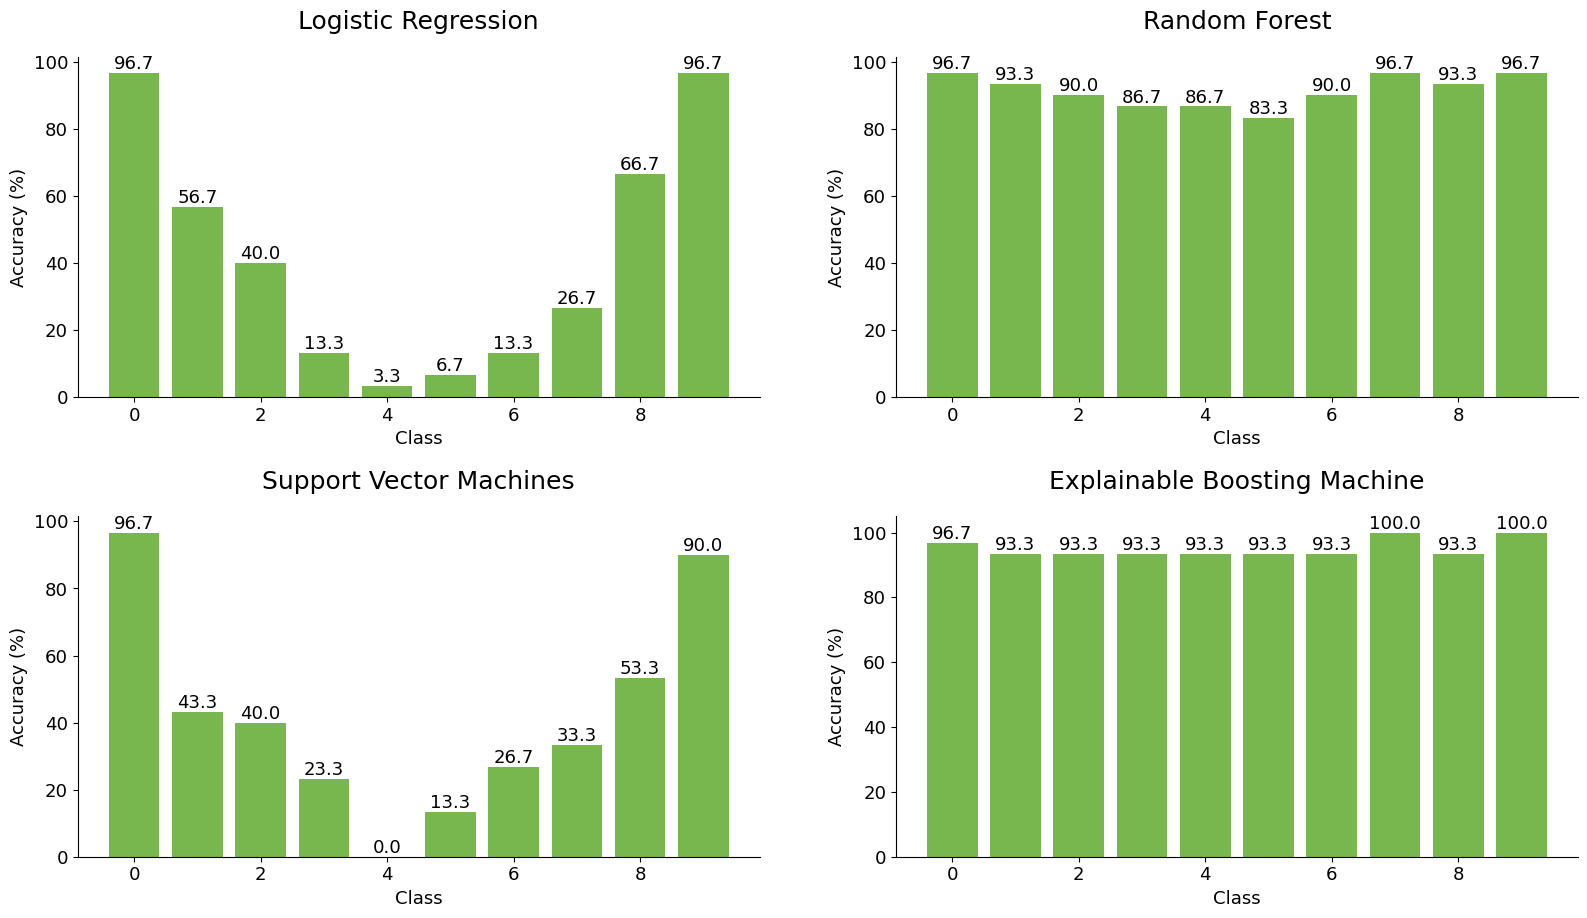

In [73]:
visual.acc_classes([lr_cm, rf_cm, svm_cm, ebm_cm],
                  nrows=2, 
                  ncols=2, 
                  figsize=(15,8),
                  title_size=title_size,
                  label_size=label_size,
                  colors=[green_color, green_color, green_color, green_color],
                  titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"])

plt.savefig(f"{logs_dir}/synth_multi_acc_classes.png", bbox_inches="tight")

plt.show()

## Local Explanations

### LIME

In [56]:
lr_LIME_explanation.show_in_notebook(show_table=True)
lr_LIME_explanation.save_to_file(f"{logs_dir}/synth_multi_LR_LIME.html")

In [57]:
rf_LIME_explanation.show_in_notebook(show_table=True)
rf_LIME_explanation.save_to_file(f"{logs_dir}/synth_multi_RF_LIME.html")

In [58]:
svm_LIME_explanation.show_in_notebook(show_table=True)
svm_LIME_explanation.save_to_file(f"{logs_dir}/synth_multi_SVM_LIME.html")

### SHAP & EBM

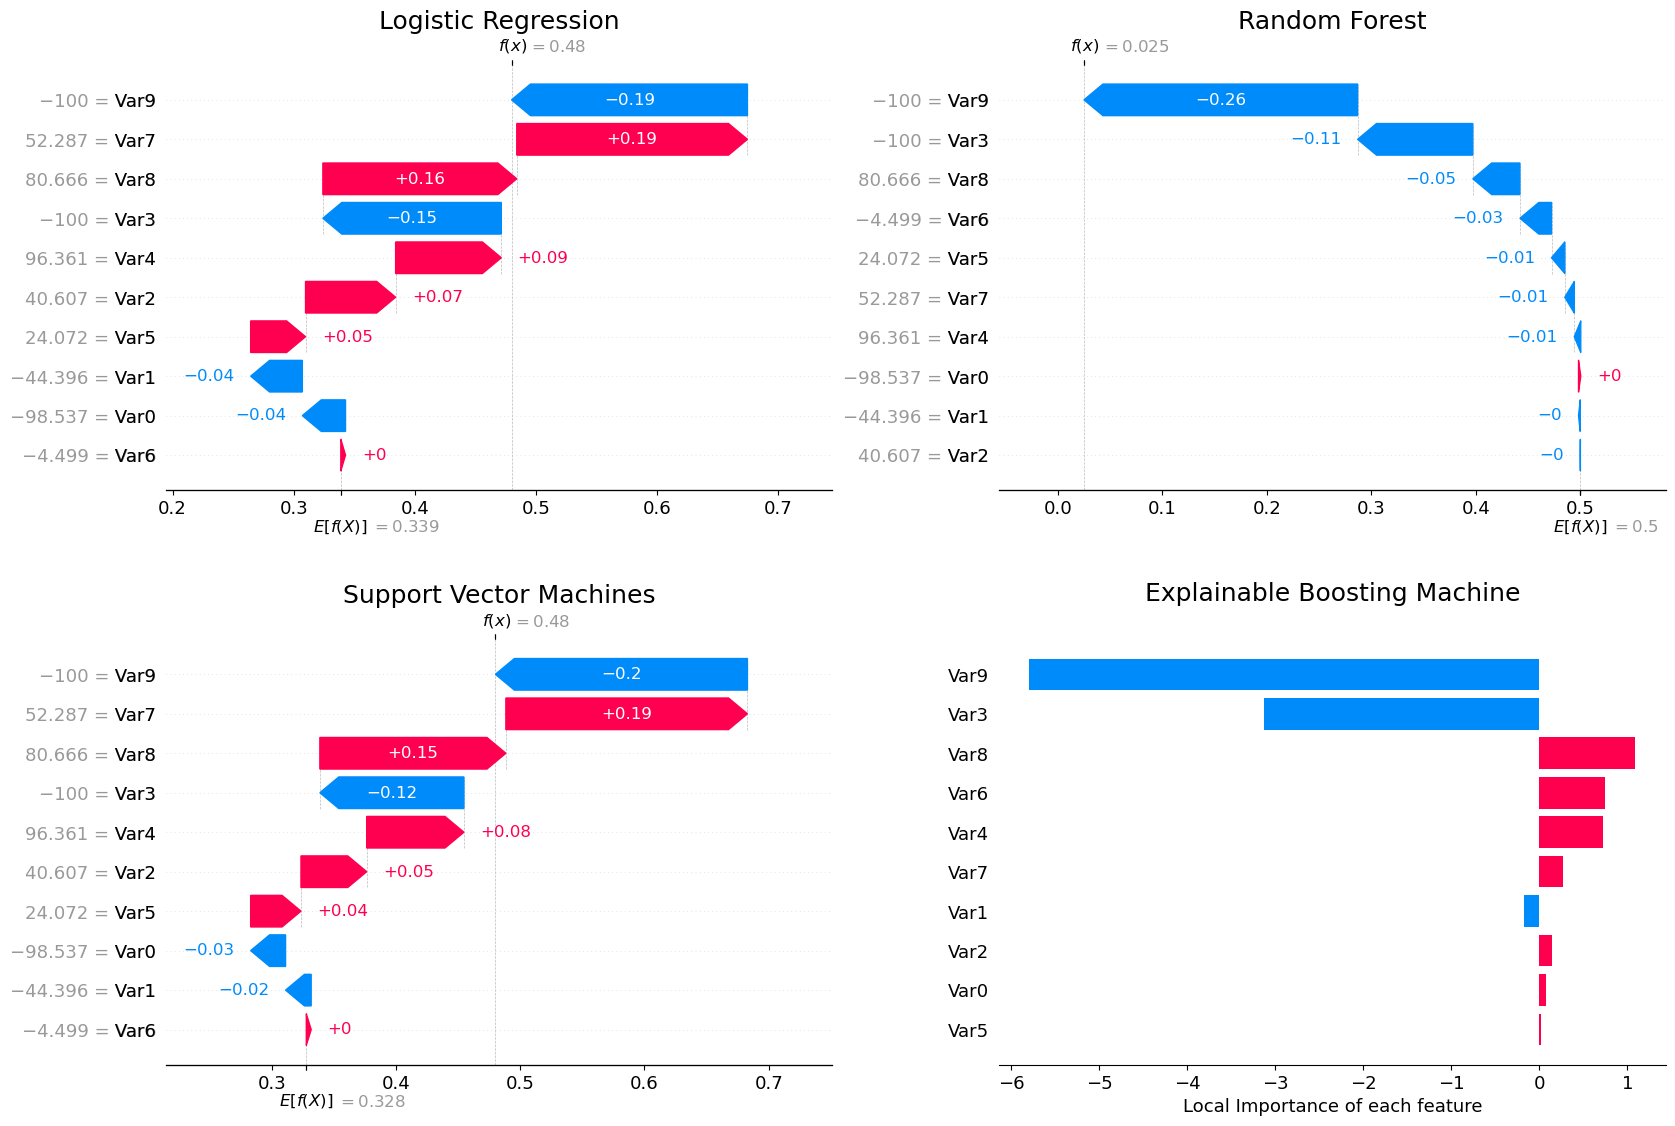

In [59]:
explanations = [shap.Explanation(lr_shap_loc_values[Exp_inst_class, :], lr_SHAP_exp.expected_value[Exp_inst_class], data=Exp_inst_pd),
                shap.Explanation(rf_shap_loc_values[Exp_inst_class, :], rf_SHAP_exp.expected_value[Exp_inst_class], data=Exp_inst_pd),
                shap.Explanation(svm_shap_loc_values[Exp_inst_class, :], svm_SHAP_exp.expected_value[Exp_inst_class], data=Exp_inst_pd)]


visual.local_shap(explanations, 
                  ebm_local.data(key=Exp_index),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255)

plt.savefig(f"{logs_dir}/synth_bin_local_SHAP_EBM.png", bbox_inches="tight")

plt.show()


## Global Explanations

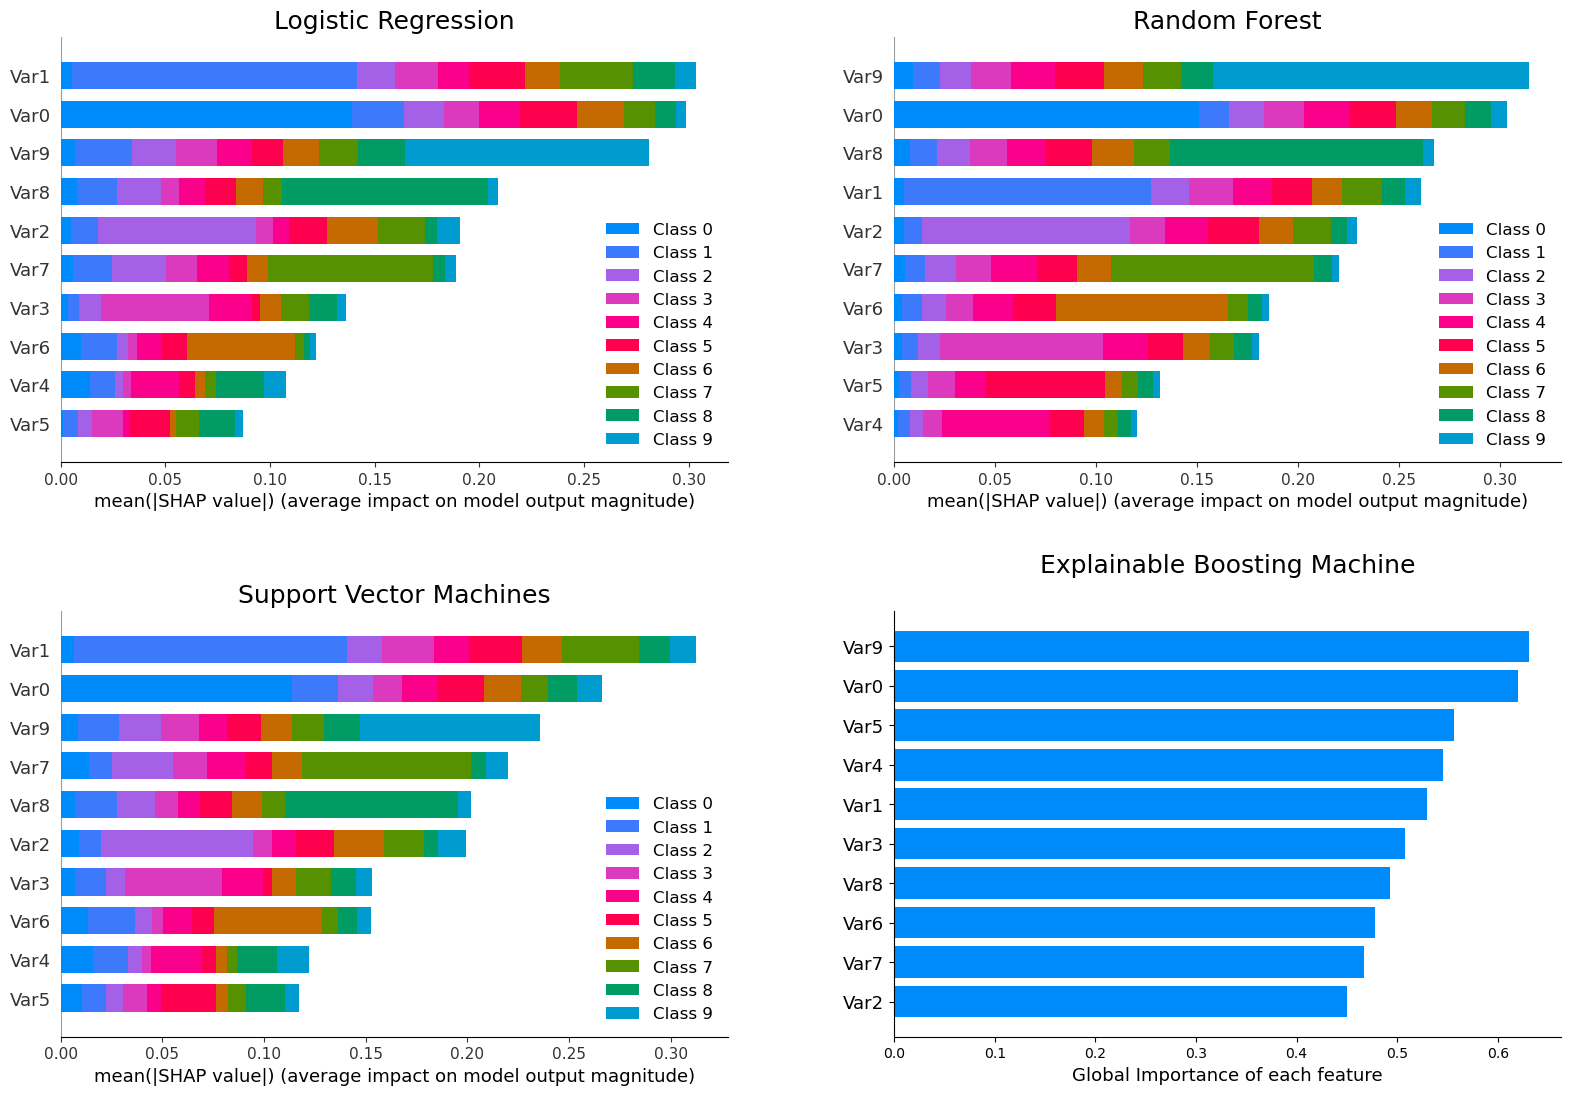

In [59]:
global_shap_values = [lr_shap_global_values,
                      rf_shap_global_values,
                      svm_shap_global_values]

visual.global_shap(global_shap_values,
                X_test_pd,
                  ebm_global.data(),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255)

plt.savefig(f"{logs_dir}/synth_multi_global_SHAP_EBM.png", bbox_inches="tight")

plt.show()